# Classification. MNIST

In [68]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [69]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [70]:
import numpy as np
import pandas as pd

In [71]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [72]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [73]:
y.shape

(70000,)

In [74]:
import matplotlib as mpl
import matplotlib.pyplot as pl

Saving figure some_digit_plot


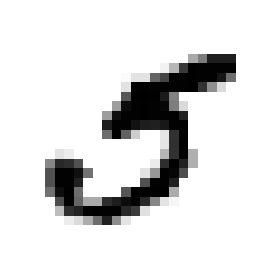

In [75]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [76]:
y[36000]


5

In [77]:
y = y.astype(np.uint8)

In [78]:
X_train, X_test, y_train, y_test =  X[:60000], X[60000:], \
                                    y[:60000], y[60000:]

In [79]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier

In [80]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [81]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [82]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

In [83]:
from sklearn.model_selection import cross_val_score

In [84]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [87]:
from sklearn.base import BaseEstimator

In [89]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [90]:
never_5_clf = Never5Classifier()

In [93]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

## Confusion matrix

In [94]:
from sklearn.model_selection import cross_val_predict

In [96]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [98]:
from sklearn.metrics import confusion_matrix

In [100]:
confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*): 53,417 of them were correctly classified as non-5s (they are called *true negatives*), while the remainin 1,162 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (the *positive class*): 1,350 were wrongly classified as non-5s (*false negatives*), while the remaining 4,071 wever correctly classified as 5s (*true positives*).

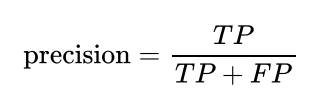

TP is the number of true positives, and FP is the number of false positives

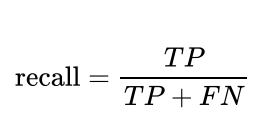

FN is, of course, the number of false negatives

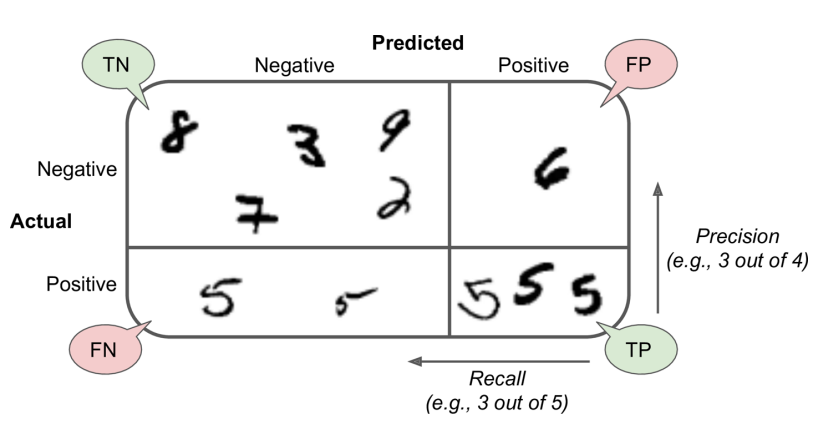

## Precision and recall

In [103]:
from sklearn.metrics import precision_score, recall_score

In [104]:
precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [105]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

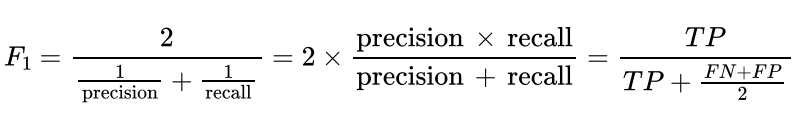

The F1 score is *harmonic mean* of precision and recall. Whereas the regualar mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [107]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

## Precision/Recall trade-off

In [109]:
y_scores = sgd_clf.decision_function([some_digit])

In [111]:
y_scores

array([150526.40944343])